Created on December 28th  2021 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

## Small experiment of document mining with various techniques Part 10

Let us use AWS built-in NTM algorithm for topic modeling

# Import libraries

In [102]:
# install NLTK and gensim if required
!pip3 -q install nltk gensim
!pip3 install texthero

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [103]:
# Import require libraries
import numpy as np
import pandas as pd
import texthero as hero
import boto3

# Setup S3 parameters

In [108]:
#initialize some parameters depending where you are running the experiment, adapt the parameters to your AWS environment
bucket='mymltextarticles'
subfolder=''
region='us-east-1'

In [109]:
# let us list the files available for analysis in the S3 bucket
import os
s3s = boto3.client('s3')
s3 = boto3.resource('s3')

#contents = s3.list_objects(Bucket=bucket, Prefix=subfolder)#['Contents']
mybucket = s3.Bucket(bucket)
mybucket.objects.filter(Prefix='foo/bar')
for file in mybucket.objects.all():
    root,ext = os.path.splitext(file.key)
    if ext in ['.txt']:
        filename=os.path.basename(file.key)
        target_filename='./sampledocs/'+filename
        print(target_filename)
        s3s.download_file(bucket, file.key, target_filename)

./sampledocs/vocab.txt
./sampledocs/AI-bank-of-the-future-Can-banks-meet-the-AI-challenge-1.txt
./sampledocs/Artificial Financial Intelligence.txt
./sampledocs/Data machine the insurers using AI to reshape the industry Financial Times.txt
./sampledocs/Digital-disruption-in-Insurance.txt
./sampledocs/Impact-Big-Data-AI-in-the-Insurance-Sector.txt
./sampledocs/Innovation_Artificial-Intelligence-in-Insurance-Whitepaper-deloitte-digital.txt
./sampledocs/Insurance-2030-The-impact-of-AI-on-the-future-of-insurance-F.txt
./sampledocs/Issues_Paper_on_Increasing_Digitalisation_in_Insurance_and_its_Potential_Impact_on_Consumer_Outcomes.txt
./sampledocs/Kaggle State of Machine Learning and Data Science 2020.txt
./sampledocs/Module-1-Lecture-Slides.txt
./sampledocs/Technology-and-innovation-in-the-insurance-sector.txt
./sampledocs/WEF_Governance_of_Chatbots_in_Healthcare_2020.txt
./sampledocs/ai-360-research.txt
./sampledocs/ai-insurance.txt
./sampledocs/ai_in_insurance_web_0.txt
./sampledocs/fra-2

# Data preparation

In [110]:
#path of text files
path='./sampledocs/'

In [111]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.txt')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    f = open(file_name,'r')
    fileText=f.read()
    docName.append(file_name)
    docType.append('txt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])


In [112]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:158638.2
Min length of text:8691
Max length of text:1513210


In [113]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,text_word_count,text_unique_words
0,./sampledocs/Technology-and-innovation-in-the-...,txt,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,16742,4228
1,./sampledocs/ai-360-research.txt,txt,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,5281,1746
2,./sampledocs/Module-1-Lecture-Slides.txt,txt,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,3728,1506
3,./sampledocs/Insurance-2030-The-impact-of-AI-o...,txt,Insurance Practice\n\nInsurance 2030—\nThe imp...,insurance practice insurance -- impact ai futu...,4424,1782
4,./sampledocs/sigma-5-2020-en.txt,txt,No 5 /2020\n\nMachine intelligence in\ninsuran...,machine intelligence insurance insights end en...,14478,4329


In [114]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               20 non-null     object
 1   Type               20 non-null     object
 2   Text               20 non-null     object
 3   cleanText          20 non-null     object
 4   text_word_count    20 non-null     int64 
 5   text_unique_words  20 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ KB


In [115]:
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
    
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

def process_text(text):
    for p in string.punctuation:
        text = text.replace(p, '')
    text = ''.join([c for c in text if not c.isdigit()])
    text = text.lower().split()
    text = [w for w in text if not w in stop_words] 
    text = [wnl.lemmatize(w) for w in text]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:
fullDocs['cleanText'] = fullDocs['cleanText'].apply(process_text)

In [117]:
fullDocs.head()

,Name,Type,Text,cleanText,text_word_count,text_unique_words
0,./sampledocs/Technology-and-innovation-in-the-...,txt,Technology and\ninnovation in the\ninsurance s...,"[technology, innovation, insurance, sector, te...",16742,4228
1,./sampledocs/ai-360-research.txt,txt,AI 360: insights from the\nnext frontier of bu...,"[ai, insight, next, frontier, business, corner...",5281,1746
2,./sampledocs/Module-1-Lecture-Slides.txt,txt,"Application of AI, Insurtech and Real Estate\n...","[application, ai, insurtech, real, estate, tec...",3728,1506
3,./sampledocs/Insurance-2030-The-impact-of-AI-o...,txt,Insurance Practice\n\nInsurance 2030—\nThe imp...,"[insurance, practice, insurance, impact, ai, f...",4424,1782
4,./sampledocs/sigma-5-2020-en.txt,txt,No 5 /2020\n\nMachine intelligence in\ninsuran...,"[machine, intelligence, insurance, insight, en...",14478,4329


In [118]:
from gensim import corpora
dictionary = corpora.Dictionary(fullDocs['cleanText'])

In [119]:
print(dictionary)

Dictionary(11382 unique tokens: ['ab', 'ability', 'able', 'abundantly', 'abusive']...)


In [120]:
dictionary.filter_extremes(keep_n=1024)
print(dictionary)

Dictionary(1024 unique tokens: ['accelerate', 'accelerating', 'acceleration', 'acceptance', 'accepted']...)


In [121]:
with open('vocab.txt', 'w') as f:
    for index in range(0,len(dictionary)):
        f.write(dictionary.get(index)+'\n')

In [122]:

fullDocs['tokens'] = fullDocs.apply(lambda row: dictionary.doc2bow(row['cleanText']), axis=1)

In [123]:
data = fullDocs.drop(['cleanText'], axis=1)
data = data.drop(['Name'], axis=1)
data = data.drop(['Type'], axis=1)
data = data.drop(['Text'], axis=1)
data = data.drop(['text_word_count'], axis=1)
data = data.drop(['text_unique_words'], axis=1)
data.head()

,tokens
0,"[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
1,"[(3, 2), (5, 1), (10, 1), (13, 1), (21, 1), (2..."
2,"[(8, 1), (11, 1), (15, 1), (16, 3), (22, 2), (..."
3,"[(0, 1), (1, 2), (7, 1), (9, 4), (11, 1), (12,..."
4,"[(0, 2), (5, 1), (6, 1), (9, 1), (10, 1), (11,..."


In [59]:
import sagemaker.amazon.common as smac
from scipy.sparse import lil_matrix

prefix = 'training'



In [60]:
def build_protobuf_dataset(data, dictionary):
    num_lines = data.shape[0]
    num_columns = len(dictionary)
    token_matrix = lil_matrix((num_lines, num_columns)).astype('float32')
    line = 0
    for _, row in data.iterrows():
        for token_id, token_count in row['tokens']:
            token_matrix[line, token_id] = token_count
        line+=1
        
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, token_matrix, None)
    return buf

In [61]:
def upload_protbuf_dataset(buf, bucket, prefix, key):
    obj = '{}/{}'.format(prefix, key)
    buf.seek(0)
    s3s.upload_fileobj(buf, bucket, obj)
    path = 's3://{}/{}'.format(bucket,obj)
    return path

In [77]:
import io
training_buf = build_protobuf_dataset(data, dictionary)
s3_training_path = upload_protbuf_dataset(training_buf, bucket, prefix, 'training/training.protobuf')
s3_auxiliary_path='Inputfiles/auxiliary/'+'vocab.txt'
s3s.upload_file('vocab.txt', bucket,'Inputfiles/auxiliary/'+'vocab.txt')

print(s3_training_path)

s3://mymltextarticles/training/training/training.protobuf


# Training

In [78]:
s3_output = 's3://{}/{}/output/'.format(bucket, prefix)

print(s3_output)

s3://mymltextarticles/training/output/


In [79]:
from sagemaker.image_uris import retrieve
from sagemaker import get_execution_role

region = 'us-east-1'  
container = retrieve('ntm', region)
print(container)

382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:1


In [80]:
role = get_execution_role()
print(role)
import sagemaker
ntm = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1, 
    instance_type='ml.c4.2xlarge',
    output_path=s3_output)

arn:aws:iam::012086180905:role/service-role/AmazonSageMaker-ExecutionRole-20211121T093897


In [81]:
ntm.set_hyperparameters(
    num_topics=10, 
    feature_dim=len(dictionary), 
    mini_batch_size=256,
    optimizer='adam',
    num_patience_epochs=10)

In [83]:
ntm.fit(inputs={'train': s3_training_path,
               'auxiliary': 's3://{}/{}'.format(bucket,s3_auxiliary_path)})

2022-01-07 12:25:30 Starting - Starting the training job...
2022-01-07 12:25:53 Starting - Launching requested ML instancesProfilerReport-1641558330: InProgress
......
2022-01-07 12:26:53 Starting - Preparing the instances for training......
2022-01-07 12:27:56 Downloading - Downloading input data
2022-01-07 12:27:56 Training - Downloading the training image......
2022-01-07 12:28:56 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[01/07/2022 12:28:59 INFO 140562606671680] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_layers': 'a

In [87]:
print(ntm.model_data)

s3://mymltextarticles/training/output/ntm-2022-01-07-12-25-30-277/output/model.tar.gz


# Load trained model
This will only work if the training completed successfully and the model is saved under the assumed location, you can change it if required

In [105]:
import sagemaker
from sagemaker import get_execution_role
s3_output='s3://mymltextarticles/training/output/ntm-2022-01-07-12-25-30-277/output/model.tar.gz'
role = get_execution_role()
ntm=sagemaker.NTMModel(s3_output, role)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [106]:
ntm_predictor = ntm.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.large')

---------!

# Model prediction using training data
This assumes that a data frame and a dictionary have been prepared using the cells above for data preparation
It also assumes the model has been loaded and the endpoint has been created

In [107]:
def prepare_samples(data, dictionary):
    num_lines = data.shape[0]
    num_columns = len(dictionary)
    line=0
    sample_matrix = np.zeros((num_lines, num_columns)).astype('float32')
    for _, row in data.iterrows():
        for token_id, token_count in row['tokens']:
            sample_matrix[line, token_id] = token_count
        line+=1

    return sample_matrix

In [124]:
samples= prepare_samples(data, dictionary)
samples.shape

(20, 1024)

In [132]:
from sagemaker.predictor import csv_serializer, json_deserializer

#ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer


ntm_predictor.serializer = sagemaker.serializers.CSVSerializer()
response = ntm_predictor.predict(samples)
print(response)

The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'topic_weights': [0.0936905593, 0.1389863044, 0.0947074741, 0.1033818498, 0.0892445073, 0.0907449126, 0.1050878465, 0.1209227517, 0.0732400194, 0.0899937451]}, {'topic_weights': [0.094230704, 0.1395254433, 0.093277961, 0.1066259518, 0.0872382745, 0.0872918889, 0.1035153791, 0.1277225912, 0.0706498697, 0.0899219587]}, {'topic_weights': [0.093900241, 0.1317909658, 0.0963539556, 0.1017725244, 0.0913976729, 0.0924328193, 0.1046868265, 0.1172470003, 0.0786318928, 0.091786094]}, {'topic_weights': [0.094006829, 0.1450598538, 0.0934277847, 0.1054858118, 0.086159043, 0.0875128135, 0.1048642397, 0.1266106516, 0.0677180365, 0.0891548917]}, {'topic_weights': [0.0937443972, 0.1378456056, 0.095006831, 0.1030102074, 0.0895280838, 0.0911481157, 0.1050277352, 0.1202597693, 0.0741740316, 0.0902552977]}, {'topic_weights': [0.0936863124, 0.1390734464, 0.0946850777, 0.1034097373, 0.0892229304, 0.090714395, 0.1050925925, 0.120972313, 0.0731692314, 0.0899739414]}, {'topic_weights': [0.09398

In [133]:
results = ntm_predictor.predict(samples)
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[[0.09369056 0.1389863  0.09470747 0.10338185 0.08924451 0.09074491
  0.10508785 0.12092275 0.07324002 0.08999375]
 [0.0942307  0.13952544 0.09327796 0.10662595 0.08723827 0.08729189
  0.10351538 0.12772259 0.07064987 0.08992196]
 [0.09390024 0.13179097 0.09635396 0.10177252 0.09139767 0.09243282
  0.10468683 0.117247   0.07863189 0.09178609]
 [0.09400683 0.14505985 0.09342778 0.10548581 0.08615904 0.08751281
  0.10486424 0.12661065 0.06771804 0.08915489]
 [0.0937444  0.13784561 0.09500683 0.10301021 0.08952808 0.09114812
  0.10502774 0.12025977 0.07417403 0.0902553 ]
 [0.09368631 0.13907345 0.09468508 0.10340974 0.08922293 0.0907144
  0.10509259 0.12097231 0.07316923 0.08997394]
 [0.09398483 0.13156515 0.09659885 0.10100279 0.09113608 0.09330544
  0.10461599 0.11660413 0.07951187 0.09167491]
 [0.09392434 0.14614722 0.09169471 0.10826065 0.08571182 0.08528025
  0.10401548 0.13066645 0.06578372 0.08851536]
 [0.09400741 0.14404917 0.0936925  0.10508219 0.08658672 0.08801821
  0.10480527 

In [96]:
import json

#response = json.loads(response)
for r in response:
    topic_vector=r.label['topic_weights'].float32_tensor.values
    top_topic= np.argmax(topic_vector)
    print(top_topic)
    #vectors = [r['topic_mixture'] for r in response['predictions']]

1
1
1
1
1
1
1
7
1
1
1
1
1
1
1
1
1
7
1


Text(0.5, 0, 'Topic ID')

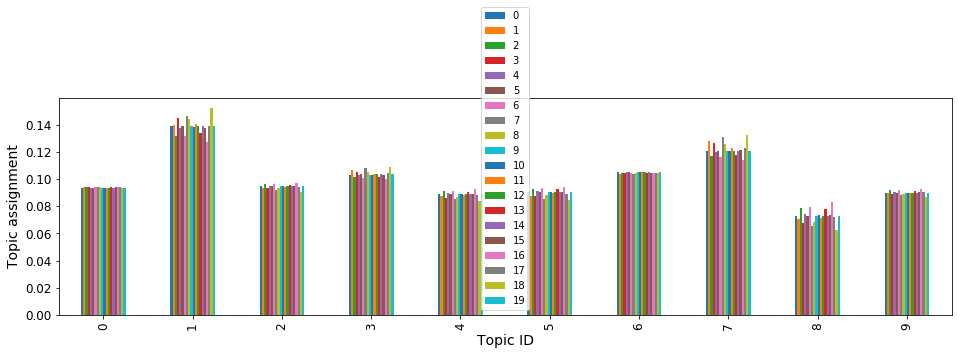

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

In [135]:
ntm_predictor.delete_endpoint()